In [24]:
#import packages
import time
import requests
import sys
import pandas as pd
from Bio import AlignIO
from pymsaviz import MsaViz

In [43]:
 #functions utilized

#requests function
def get_url(url, **kwargs):
    response = requests.get(url, **kwargs)
    if not response.ok:
        print(response.text)
        response.raise_for_status()
        sys.exit()

    return response

#check the status of the alignment job
def status_check():
    if job_status.text == 'RUNNING' or job_status.text == 'QUEUED':
        print(job_status.text)
        return True
    else:
        print('FINISHED')
        return False

#show the alignment once job has completed
def show_alignment():
    query_alignment = get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/result/{job_id}/aln-clustal_num")
    print(query_alignment.text)

In [26]:
#constants
UNIPROT_ENDPOINT = 'https://rest.uniprot.org'
QUERY = input("Enter the gene name").lower()
EXPECTED_LENGTH = int(input("Enter the expected length of the protein"))
MIN_SEQ_LENGTH = EXPECTED_LENGTH - (EXPECTED_LENGTH * 0.05)

In [27]:
#read and convert taxonomy csv to a dictionary
df = pd.read_csv('species_dataset.csv',
                 usecols=['Taxon Id', 'Common name', 'Scientific name'])

result = df.to_dict(orient='records')

In [28]:
#create new dictionary of only scientific name and taxon ID
taxon_id_list = []
scientific_name_list = []

for ids in result:
    for key in ids:
        if key == 'Taxon Id':
            taxon_id = ids[key]
            taxon_id_list.append(taxon_id)
        if key == 'Scientific name':
            scientific_name = ids[key]
            scientific_name_list.append(scientific_name)

taxonomy_dict = dict(zip(scientific_name_list, taxon_id_list))

In [29]:
#create an accession list which will be used to query and retrieve sequences
accession_list = []
accession_dict = {}

for tax_id in taxonomy_dict.values():
    r = get_url(f"{UNIPROT_ENDPOINT}/uniprotkb/search?query={QUERY} AND (taxonomy_id: {tax_id})")
    data = r.json()
    # n_results = len(data["results"])
    # print(f"Number of results: {n_results}\n")
    for sequences in data['results']:
        protein_existence = sequences['proteinExistence']

        if (protein_existence == '1: Evidence at protein level' or
                protein_existence == '2: Evidence at transcript level' or
                protein_existence == '3: Inferred from homology'):

            try:
                seq_len = int(sequences['sequence']['length'])
                gene_name = (sequences['genes'][0]['geneName']['value']).lower()
                
                if  gene_name == QUERY:
            
                    if seq_len >= MIN_SEQ_LENGTH:
                        accession_id = sequences['primaryAccession']
                        sequence = sequences['sequence']
                        accession_dict[accession_id] = sequence
                        accession_list.append(sequences['primaryAccession'])
                        break
            except KeyError:
                break
print(accession_list)

['A0A2K5S9X7', 'A0A2K6JS16', 'A0A2K6N9D6', 'G1R4F8', 'H0ZKS5', 'U3JP74', 'A0A0D9RIL7', 'I3LYF1', 'A0A2K6TJS1', 'A0A2K5DYH8', 'G1KCN0', 'H0X892', 'E7DX60', 'F6QWE0', 'K7G339', 'H3B5H6', 'A0A8B9K751', 'A0A3B3HAX7', 'A0A165G1F9', 'U3IXM5', 'O42220', 'O42221', 'A0A6I8PB41', 'G3WMK7', 'F6Y9D0', 'A0A2K5NJ43', 'Q95J86', 'A1C2U6', 'A0A2K6B5Y9', 'A0A096NPW9', 'A0A2K5XGM4', 'A1C2V5', 'A1C2U7', 'A1C2V0', 'O14793', 'Q6UKZ8', 'D2HA19', 'M3YLV6', 'M3WPT7', 'G3TG77', 'Q9GM97', 'O18831', 'O18836', 'O18830', 'A7LH84', 'O08689', 'O35312', 'A0A286XWP0']


In [42]:
#join the list and create a fasta
joined = ','.join(accession_list)
align_response = get_url(f"{UNIPROT_ENDPOINT}/uniprotkb/accessions?accessions={joined}&format=fasta")
fasta = align_response.text
with open(f'{QUERY}_unaligned.fasta', 'w+') as file:
    file.writelines(fasta)
print(fasta)

>tr|A0A2K5S9X7|A0A2K5S9X7_CEBIM Growth/differentiation factor 8 OS=Cebus imitator OX=2715852 GN=MSTN PE=3 SV=1
MQKLQLYVYIYLFMLIVAGSVDLNENSEHNENVEKEGLCNTCTWRQNTKSSRIEAIKIQI
LSKLRLETAPNISKDAIRQLLPKAPPLRELIDQYDVQRDDSSDGSLEDDDYHATTETIIT
MPTESDFLTQADGKPKCCFFKFSSKIQYNKVVKAQLWIYLKPVKTPTTVFVQILRLIKPM
KDGTRYTGIRSLKLDMNPGTGIWQSIDVKTVLQNWLKQPESNLGIEIKALDDNGHDLAVT
FPESKENGLNPFLEVKVTDTPKRSRRDFGLDCDDLSTETRCCRYPLTVDFEAFGWDWIIA
PKRYKANYCSGECDFVFLQKYPHTHLVHQANPKGSAGPCCTPTKMSPINMLYFNGKEQII
YGKIPAMVVDRCGCS
>tr|A0A2K6JS16|A0A2K6JS16_RHIBE Growth/differentiation factor 8 OS=Rhinopithecus bieti OX=61621 GN=MSTN PE=3 SV=1
IMQKLQLCVYIYLFMLIVAGPVDLNENSEQKENVEKEGLCNACTWRQNTKSSRIEAIKIQ
ILSKLRLETAPNISKDAIRQLLPKAPPLRELIDQYDVQRDDSSDGSLEDDDYHATTETII
TMPTESDFLMRMDGKPKCCFFKFSSKIQYNKVVKAQLWIYLRPVETPTTVFVQILRLIKP
MKDGTRYTGIRSLKLDMNPGTGIWQSIDVKTVLQNWLKQPESNLGIEIKALDENGHDLAV
TFPGPGEDGLNPFLEVKVTDTPKRSRRDFGLDCDEHSTESRCCRYPLTVDFEAFGWDWII
APKRYKANYCSGECEFVFLQKYPHTHLVHQANPRGSAGPCCTPTKMSPINMLYFNGKEQI
IYGKIPAMVVDRCGCS
>tr|A0A2K6

In [39]:
#submit and monitor job status
response_alignment = requests.post("https://www.ebi.ac.uk/Tools/services/rest/clustalo/run", data={
    "email": "example@example.com",
    "iterations": 0,
    "outfmt": "clustal_num",
    "order": "aligned",
    "sequence": fasta
})

job_id = response_alignment.text
job_status = get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/status/{job_id}")

while status_check():
    job_status = get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/status/{job_id}")
    time.sleep(3)

QUEUED
QUEUED
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
FINISHED


In [32]:
#show alignment
show_alignment()

CLUSTAL O(1.2.4) multiple sequence alignment


tr|A0A8B9K751|A0A8B9K751_ASTMX      ----------------------------------------------------------MH	2
tr|A0A3B3HAX7|A0A3B3HAX7_ORYLA      MISIRVAHLSKHGYLRIRSTLPQ-------RIFVFFFKKKSQT----NKQNKRHTSETMD	49
tr|E7DX60|E7DX60_TAKRU              ----------------------------------------------------------MQ	2
tr|A0A165G1F9|A0A165G1F9_ORENI      ----------------------------------------------------------MH	2
tr|H3B5H6|H3B5H6_LATCH              ----------------------------------------------------------MQ	2
tr|A0A6I8PB41|A0A6I8PB41_ORNAN      ------------------------------------MGPGSG----RGRGRG------WG	14
tr|G1KCN0|G1KCN0_ANOCA              ----------------------------------------------------------MQ	2
tr|K7G339|K7G339_PELSI              ----------------------------------------------------------MQ	2
sp|O42220|GDF8_CHICK                ----------------------------------------------------------MQ	2
sp|O42221|GDF8_MELGA                ------------------------

In [33]:
#create text file
alignment = (get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/result/{job_id}/aln-clustal_num")).text

with open(f'{QUERY}_aligned_MSA.aln', 'w+') as file:
    file.writelines(alignment)

In [35]:
#turn MSA file into fasta file using BioPython
def convert_clustal_to_fasta(input_file, output_file):
    # Parse the CLUSTAL file and read the alignment
    clustal_alignment = AlignIO.read(input_file, "clustal")

    # Write the alignment in FASTA format
    with open(output_file, "w") as fasta_file:
        AlignIO.write(clustal_alignment, fasta_file, "fasta")

if __name__ == "__main__":
    input_clustal_file = f"{QUERY}_aligned_MSA.aln"
    output_fasta_file = f"{QUERY}_aligned_fasta.fasta"

    convert_clustal_to_fasta(input_clustal_file, output_fasta_file)

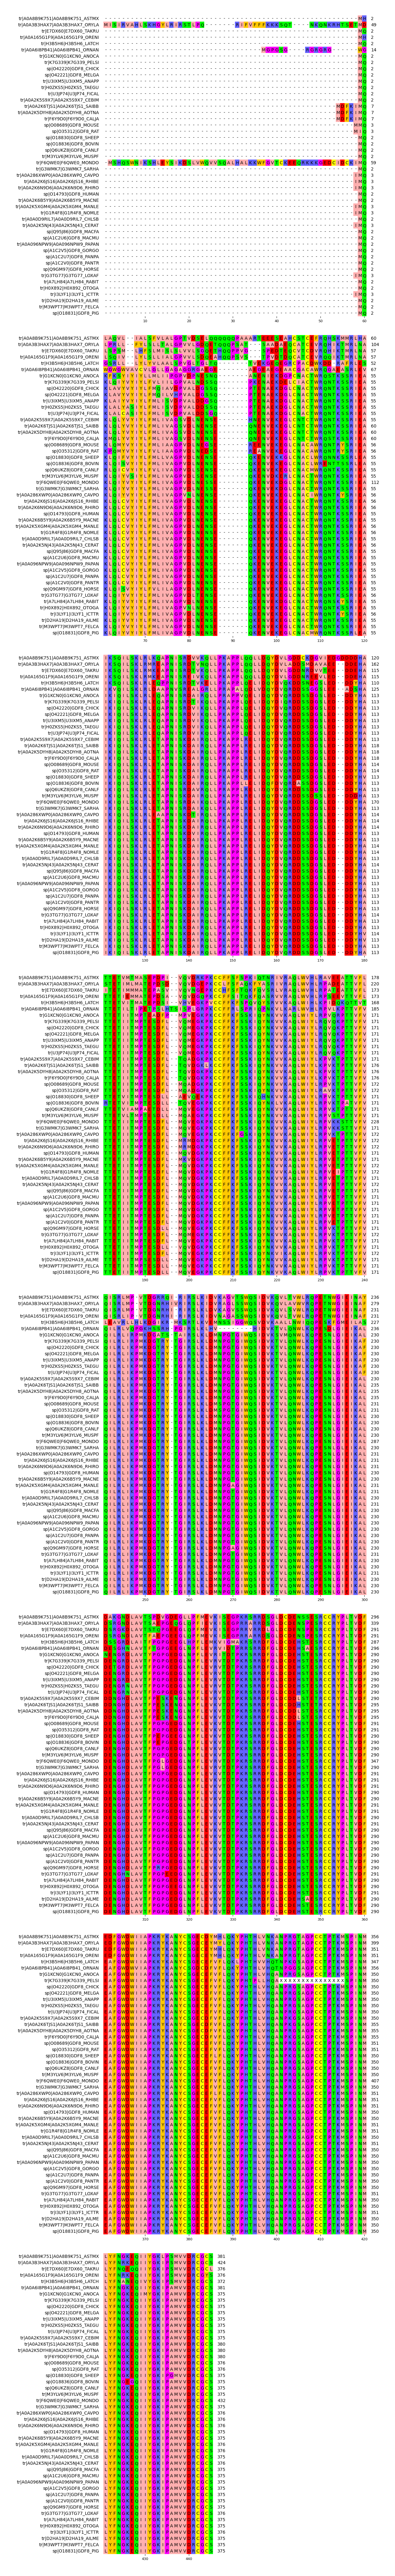

In [36]:
msa_file = open(output_fasta_file)
mv = MsaViz(msa_file, wrap_length=60, show_count=True)
mv.savefig(f"{QUERY}.png")